In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
# import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

# Load inhibition data 

In [2]:
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/inhib'
train_x_df = pd.read_csv(split_path+"/inhib_train_x_ADASYN.csv")
train_y_df= pd.read_csv(split_path+"/inhib_train_y_ADASYN.csv")
test_x_df= pd.read_csv(split_path+"/inhib_test_x_ADASYN.csv")
test_y_df= pd.read_csv(split_path+"/inhib_test_y_ADASYN.csv")
train_x = train_x_df.to_numpy()
train_y = train_y_df.to_numpy().reshape(-1)
test_x = test_x_df.to_numpy()
test_y = test_y_df.to_numpy().reshape(-1)


# ADASYN

In [3]:
# # Scale data
# x_df = pd.concat([train_x_df, test_x_df])

# scaling=StandardScaler()

# # Use fit and transform method 
# scaling.fit(x_df)
# Scaled_data=scaling.transform(x_df)
# train_x = scaling.transform(train_x_df)
# test_x = scaling.transform(test_x_df) 

# adasyn = ADASYN() 
# train_x_temp, train_y_temp = adasyn.fit_resample(train_x, train_y_df)
# train_x = train_x_temp
# train_y = train_y_temp.to_numpy().flatten()
# test_y = test_y_df.to_numpy().flatten()


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.924, precision: 0.452, recall: 0.500, sensitivity: 0.500, specificity: 0.955


<Figure size 600x400 with 0 Axes>

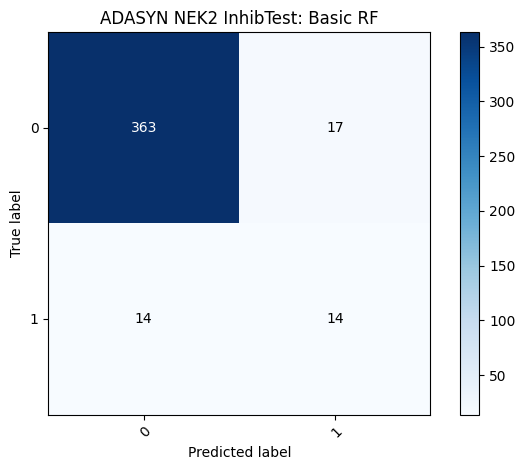

In [3]:
rf_basic100estADASYN= rf_models(train_x, train_y, test_x, test_y, 'basic RF', {}, 'inhibition')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, rf_basic100estADASYN['test_pred'], ['0','1'], title='ADASYN NEK2 InhibTest: Basic RF')

# Reduced param grid for grid search - RUN IN BASH SCRIPT 

In [4]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [4]:
save_file = 'atom_nek2inhibADASYN_rf_basic_best.pkl'
# rf_basicbestADASYN = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,  save_file, 2)

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


TRAIN: accuracy: 0.987, precision: 1.000, recall: 0.975, sensitivity: 0.975, specificity: 1.000
TEST: accuracy: 0.912, precision: 0.367, recall: 0.393, sensitivity: 0.393, specificity: 0.950


<Figure size 600x400 with 0 Axes>

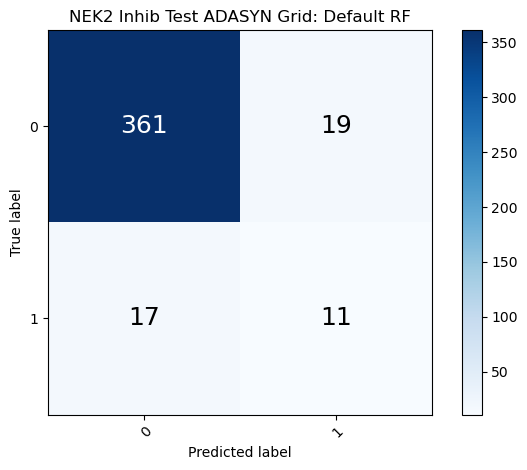

In [5]:
# with open(save_file, 'wb') as f:
#         pickle.dump(rf_basicbestADASYN['best_model'], f)
with open('saved_models/'+save_file, 'rb') as f: 
    rf_basicbestADASYN = pickle.load(f) 
grid_results = rf_results2(rf_basicbestADASYN, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results['test_pred'], ['0','1'], title='NEK2 Inhib Test ADASYN Grid: Default RF')



In [15]:
for param, value in rf_basicbestADASYN.get_params().items():
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: entropy
max_depth: 200
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 1050
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


# Basic RF + classweight balanced 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.927, precision: 0.477, recall: 0.750, sensitivity: 0.750, specificity: 0.940


<Axes: title={'center': 'ADASYN NEK2 Inhib Test: RF + Balanced Class Weight'}, xlabel='Predicted label', ylabel='True label'>

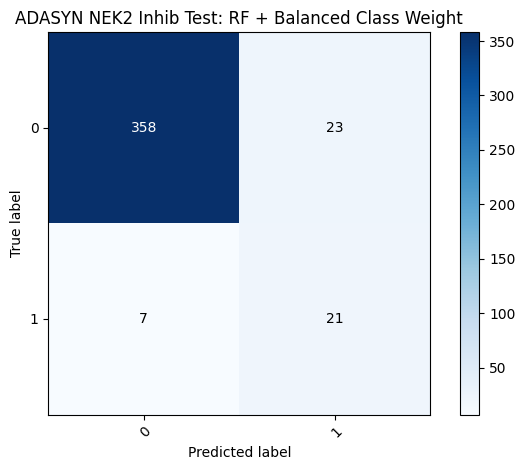

In [5]:
brf_model_BCW_ADASYN = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, 'inhibition')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, brf_model_BCW_ADASYN['test_pred'], ['0','1'], title='ADASYN NEK2 Inhib Test: RF + Balanced Class Weight')

In [7]:
save_file2 = 'atom_nek2inhibADASYN_rf_basicBCW_best.pkl'
# rf_basicBCWbestADASYN = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid,  save_file2, 2)

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


TRAIN: accuracy: 0.986, precision: 0.999, recall: 0.973, sensitivity: 0.973, specificity: 0.999
TEST: accuracy: 0.909, precision: 0.355, recall: 0.393, sensitivity: 0.393, specificity: 0.947


<Figure size 600x400 with 0 Axes>

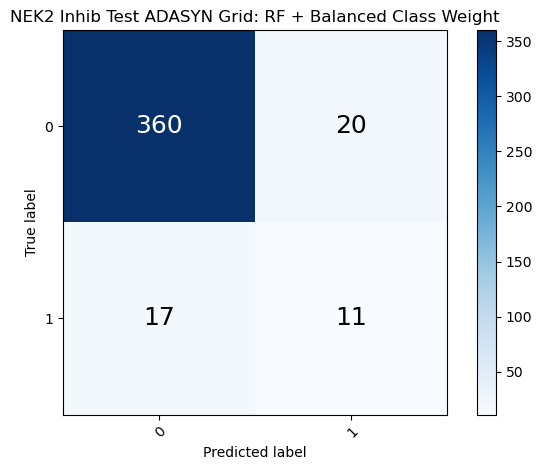

In [8]:
# with open(save_file2, 'wb') as f:
#     pickle.dump(rf_basicBCWbestADASYN['best_model'], f)

with open('saved_models/'+save_file2, 'rb') as f: 
    rf_basicBCWbestADASYN = pickle.load(f) 

grid_results2 = rf_results2(rf_basicBCWbestADASYN, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results2['test_pred'], ['0','1'], title='NEK2 Inhib Test ADASYN Grid: RF + Balanced Class Weight')



In [16]:
for param, value in rf_basicBCWbestADASYN.get_params().items():
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: entropy
max_depth: 20
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 4
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 2000
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


# Balanced Random Forest Classifier

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.922, precision: 0.455, recall: 0.714, sensitivity: 0.714, specificity: 0.937


<Axes: title={'center': 'ADASYN NEK2 Inhib Test: Balanced RFC'}, xlabel='Predicted label', ylabel='True label'>

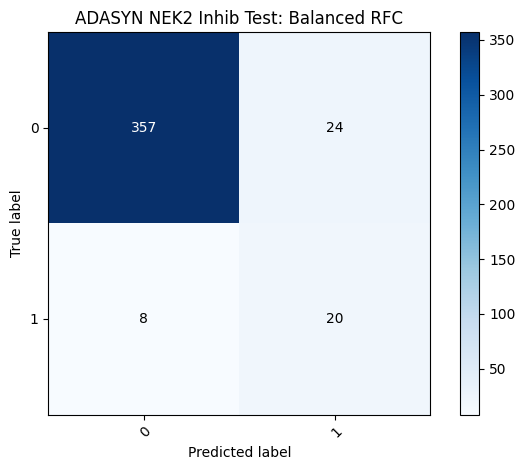

In [6]:
brf_modelADASYN = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, 'inhibition')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, brf_modelADASYN['test_pred'], ['0','1'], title='ADASYN NEK2 Inhib Test: Balanced RFC')

In [10]:
save_file3 = 'atom_nek2inhibADASYN_BRFC_best.pkl'
# brfc_bestADASYN = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, param_grid,  save_file3, 2)


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


TRAIN: accuracy: 0.987, precision: 0.999, recall: 0.974, sensitivity: 0.974, specificity: 0.999
TEST: accuracy: 0.912, precision: 0.367, recall: 0.393, sensitivity: 0.393, specificity: 0.950


<Figure size 600x400 with 0 Axes>

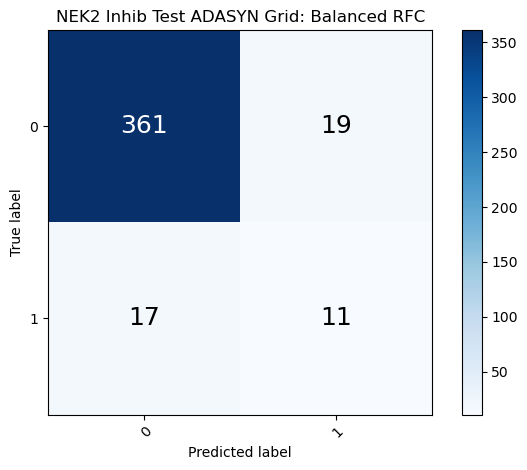

In [11]:
# with open(save_file3, 'wb') as f:
#     pickle.dump(brfc_bestADASYN['best_model'], f)

with open('saved_models/'+save_file3, 'rb') as f: 
    brfc_bestADASYN = pickle.load(f) 


grid_results3 = rf_results2(brfc_bestADASYN, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results3['test_pred'], ['0','1'], title='NEK2 Inhib Test ADASYN Grid: Balanced RFC')



In [17]:
for param, value in brfc_bestADASYN.get_params().items():
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: entropy
max_depth: 20
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 4
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 2000
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


# Try BRFC with balanced class weight & bootstrap

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.924, precision: 0.467, recall: 0.750, sensitivity: 0.750, specificity: 0.937


<Axes: title={'center': 'ADASYN NEK2 Inhib Test: Balanced RFC + Balanced Class Weight'}, xlabel='Predicted label', ylabel='True label'>

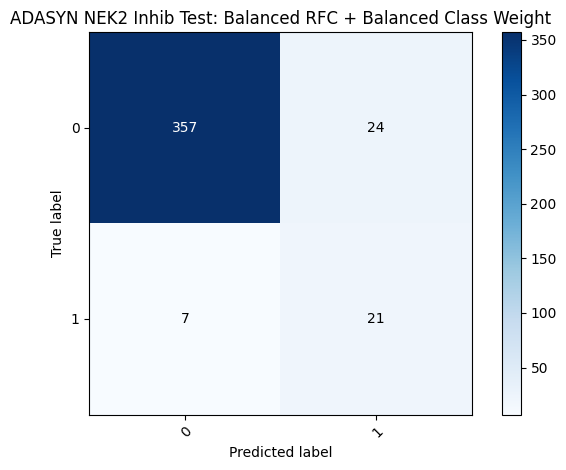

In [7]:
brf_modelCWB_ADASYN = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, 'inhibition')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, brf_modelCWB_ADASYN['test_pred'], ['0','1'], title='ADASYN NEK2 Inhib Test: Balanced RFC + Balanced Class Weight')

In [12]:
save_file4 = 'atom_nek2inhibADASYN_BRFC_BCW_best.pkl'
# brfc_BCW_ADASYN_best = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, param_grid,  save_file4, 2)

# with open(save_file4, 'wb') as f:
#     pickle.dump(brfc_BCW_ADASYN_best['best_model'], f)

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


TRAIN: accuracy: 0.986, precision: 0.999, recall: 0.972, sensitivity: 0.972, specificity: 0.999
TEST: accuracy: 0.917, precision: 0.393, recall: 0.393, sensitivity: 0.393, specificity: 0.955


<Figure size 600x400 with 0 Axes>

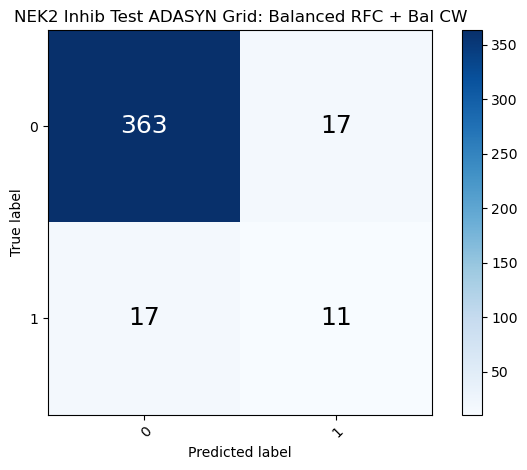

In [13]:
with open('saved_models/'+save_file4, 'rb') as f: 
    brfc_BCW_ADASYN_best = pickle.load(f) 


grid_results4 = rf_results2(brfc_BCW_ADASYN_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results4['test_pred'], ['0','1'], title='NEK2 Inhib Test ADASYN Grid: Balanced RFC + Bal CW')


In [18]:
for param, value in brfc_BCW_ADASYN_best.get_params().items():
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: entropy
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 4
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 1050
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [14]:
nek2inhib_ADASYNmodels = {'default_RF':rf_basicbestADASYN, 'rf_bcw':rf_basicBCWbestADASYN,
                              'BRFC':brfc_bestADASYN, 'BRFC_bcw':brfc_BCW_ADASYN_best}

with open('nek2inhib_ADASYNmodels.pkl', 'wb') as f:
    pickle.dump(nek2inhib_ADASYNmodels, f)
